# Linear Classification with Stochastic Gradient Descend/Ascend



Classification datasets: 

- Bank Marketing: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing (predict whether or not a bank client will default)

- Occupancy Detection: https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+  (occupancy detection of an office room from light, temperature, humidity and CO2 measurements using statistical learning models)


In [ ]:
#import dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


#load bank marketing dataset
path = "/content/drive/My Drive/bank.csv"
bank_data = pd.read_csv(path, sep=';')
bank_data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


From the above table, notice that columns job, marital, education, housing, loan, cellular, month and poutcome are all non-numerical. In order to learn a regression model on this dataset, we need to convert these columns to numerical values.

In [ ]:
#load occupancy detection dataset
path = "/content/drive/My Drive/datatraining.txt"
occupancy_data = pd.read_csv(path, sep=',')
occupancy_data.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
3,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
4,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
5,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [ ]:
#are there null values in the datasets?
#number of null values in bank_data
nulls_bank = bank_data.isnull().values.sum()
print("Number of null values in bank_data: {}".format(nulls_bank))


Number of null values in bank_data: 0


In [ ]:
#number of null values in occupancy_data
nulls_occup = occupancy_data.isnull().values.sum()
print("Number of null values in occupancy_data: {}".format(nulls_occup))

Number of null values in occupancy_data: 0


#### Split data into train (80%) and test (20%)

In [ ]:
#split function
def split_train_test(dataset, size):
  train_set = dataset.sample(frac=size)
  test_set = dataset.drop(train_set.index)
  return train_set, test_set

In [ ]:
#splitting bank data
bank_train, bank_test = split_train_test(bank_data, 0.8)
#features and target
x_train_bank = bank_train.drop(['y'], axis=1)
y_train_bank = bank_train['y'].map({'yes':1 , 'no':0})

x_test_bank = bank_test.drop(['y'], axis=1)
y_test_bank = bank_test['y'].map({'yes':1, 'no':0})


#splitting room occupancy data
occup_train, occup_test = split_train_test(occupancy_data, 0.8)
x_train_occup = occup_train.drop(['date', 'Occupancy'],axis=1) 
y_train_occup = occup_train['Occupancy']

x_test_occup = occup_test.drop(['date','Occupancy'], axis=1)
y_test_occup = occup_test['Occupancy']
#

In [ ]:
x_train_bank.shape

(3617, 16)

In [ ]:
y_train_bank.shape

(3617,)

#### Convert non-numeric to numeric values

In [ ]:
#get numeric values for x_train_bank and x_test_bank
x_train_bank = pd.get_dummies(x_train_bank)
x_test_bank = pd.get_dummies(x_test_bank)

x_train_bank.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
12,36,1109,13,328,2,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3103,34,61,5,21,1,-1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
578,49,171,4,19,3,175,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
712,28,102,28,321,2,-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1
2896,80,1548,6,331,2,-1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


#### Normalize bank train and test data

In [ ]:
#The following fields will be normalized in the Bank Marketing Dataset: age, balance, day, duration, campaign, pdays and previous.
for i in ['age', 'balance', 'day', 'duration', 'pdays', 'previous']:
  x_train_bank[i] = (x_train_bank[i] - x_train_bank[i].min())/(x_train_bank[i].max() - x_train_bank[i].min())
  x_test_bank[i]  = (x_test_bank[i] - x_test_bank[i].min()) / (x_test_bank[i].max() - x_test_bank[i].min())

In [ ]:
x_test_bank.head()

,age,balance,day,duration,campaign,pdays,previous,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,education_primary,education_secondary,education_tertiary,education_unknown,default_no,default_yes,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,contact_unknown,month_apr,month_aug,month_dec,month_feb,month_jan,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
6,0.216667,0.119149,0.433333,0.166008,1,0.411180,0.105263,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0
8,0.300000,0.116319,0.433333,0.025692,2,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
10,0.266667,0.417583,0.633333,0.132411,1,0.000000,0.000000,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
14,0.133333,0.120894,0.933333,0.041502,1,0.300621,0.052632,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
23,0.350000,0.112106,0.200000,0.059289,2,0.000000,0.000000,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1


### Linear classification with GD

In [ ]:
#funcitons to be used
#1. log likelihood function
def log_likelihood(x,y,beta):
  approx = y * (x.dot(beta.T))
  exp = 1 + np.exp((x.dot(beta.T)))
  return sum(approx - np.log(exp))

#2. compute gradient
def get_grad(x,y, y_pred):
  residual = y - y_pred
  return np.dot(residual, x)

#3. compute y_pred
def compute_ypred(x,beta):
  return 1/(1 + np.exp(x.dot(beta)))


#### With Bold-driver step

In [ ]:
#function for bold-driver step
def boldDriver_step(x, y, beta, alpha_old, alpha_inc,alpha_dec, D):
  #compute obj func
  fx = log_likelihood(x,y,beta)
  #get new alpha by increamenting old alpha 
  alpha = alpha_old * alpha_inc

  while fx - log_likelihood(x, y, (beta + alpha*D)) <= -0.001:
    #get new alpha by decreamenting alpha
    alpha = alpha * alpha_dec
  
  return alpha

#get values of alpha
def compute_alpha_bdriver(x,y,beta, prev_beta):
  y_pred = compute_ypred(x, beta)
  grad = get_grad(x,y,y_pred)
  #compute new values for step 
  new_alpha = boldDriver_step(x,y, beta, prev_beta, 1.1, 0.5, grad)
  return new_alpha

#### Stochastic Gradient Ascent with Bold Driver Step length

In [ ]:
""" Here, we define a function that initially generates a random list of numbers from 0 to the length of the training dataset.
This list will be used to randomly go over the different rows of the dataset.In each iteration over a randome rows of the dataset, the function will update values of beta.
Once the function has updated beta over all the rows of the dataset, it will return the new beta value.
Note: SGA because we want to maximize the likelihood of belonging to a certain class"""
def SGA_bdriver(x,y, beta, alpha):
  #set beta to previous beta
  prev_beta = beta
  #get list of random ints
  rand_list = np.random.randint(0, x.shape[0], x.shape[0])

  #update values of beta for each selected random row
  for n in rand_list:
    y_pred = compute_ypred(x.iloc[n], prev_beta)
    grad = get_grad(x.iloc[n], y.iloc[n], y_pred)
    beta = prev_beta + alpha*grad 
    return beta

### Learn Logistic regression with SGA

In [ ]:
#
def LEARN_LOGREG_SGA(x_train, y_train, max_iter, x_test, y_test):
  #Set initial beta vector as a vector of 0s.
  beta = np.zeros(x_train.shape[1])
  #Set initial learning rate, alpha = 0.01
  alpha = 0.01
  #Set epsillon = 0.05
  epsillon = 0.05

  loss_diff = []
  log_loss_list = []
  initial_log_likelihood = log_likelihood(x_train, y_train, beta)
  #For n maximum number of iterations:
  for i in range(max_iter):
    prev_log = initial_log_likelihood
    #get alpha
    alpha = compute_alpha_bdriver(x_train, y_train, beta, alpha)
    #update beta
    beta  = SGA_bdriver(x_train, y_train, beta, alpha)
    #compute log_likelihood 
    log_liklhd = log_likelihood(x_train, y_train, beta)

    #loss differences
    loss_difference = abs(log_liklhd - prev_log)
    #append difference
    loss_diff.append(loss_difference)

    #compute log_loss on test set
    log_loss_test = log_likelihood(x_test, y_test, beta)
    #append results
    log_loss_list.append((log_loss_test))

    #convergence analysis
    #if converged 
    if loss_difference < epsillon:
      print("Model converged after {} iterations".format(i))
      return loss_diff, log_loss_list
  #if not converged 
  print("Model did not converge after {} iterations".format(max_iter))
  return loss_diff, log_loss_list

#### Evaluation

In [ ]:
#model evaluation on bank dataset
#hyperparameter
max_iter = 500

#model results
loss_diff_bank, log_loss_list_bank = LEARN_LOGREG_SGA(x_train_bank, y_train_bank,max_iter, x_test_bank, y_test_bank)

Model did not converge after 500 iterations


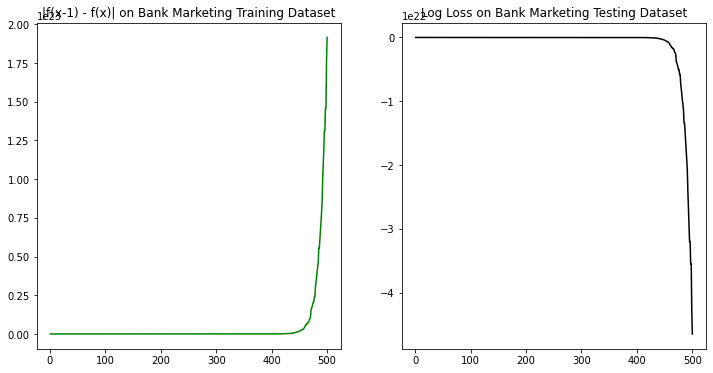

In [ ]:
#plot
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size

fig, axarr= plt.subplots(1, 2)

axarr[0].set_title("|f(x-1) - f(x)| on Bank Marketing Training Dataset")
axarr[0].plot(np.arange(1,len(loss_diff_bank) +1), loss_diff_bank, color="green")

axarr[1].set_title("Log Loss on Bank Marketing Testing Dataset")
axarr[1].plot(np.arange(1,(len(log_loss_list_bank) +1)), log_loss_list_bank, color = "black")

plt.show()

In [ ]:
#model evaluation on Room Occupancy dataset
#model results
max_iter = 100
loss_diff_occ, log_loss_list_occ = LEARN_LOGREG_SGA(x_train_occup, y_train_occup,max_iter, x_test_occup, y_test_occup)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


Model did not converge after 100 iterations


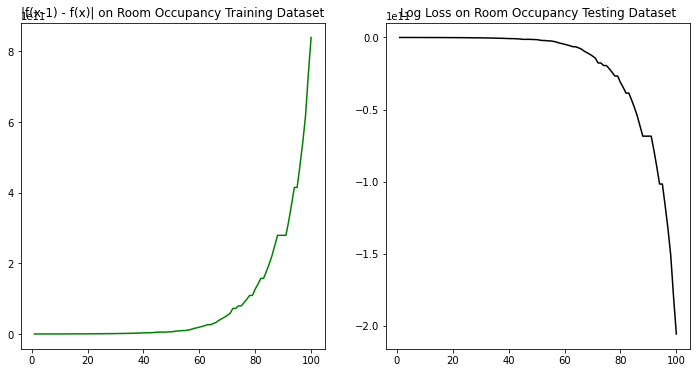

In [ ]:
#plot
fig_1, axarr_1= plt.subplots(1, 2)

axarr_1[0].set_title("|f(x-1) - f(x)| on Room Occupancy Training Dataset")
axarr_1[0].plot(np.arange(1,len(loss_diff_occ) +1), loss_diff_occ, color="green")

axarr_1[1].set_title("Log Loss on Room Occupancy Testing Dataset")
axarr_1[1].plot(np.arange(1,(len(log_loss_list_occ) +1)), log_loss_list_occ, color = "black")

plt.show()